*Nhóm 5_ Bài tập lớn cuối kỳ Machine Learning*

---


**IMAGE CAPTIONING**
---



#**1. Prepare Data**

##Import các thư viện cần thiết

In [ ]:
import os
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm.notebook import tqdm
from keras.models import Model, load_model
from keras.preprocessing.text import Tokenizer
from nltk.translate.bleu_score import corpus_bleu
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from keras.utils import to_categorical, plot_model, load_img, img_to_array, pad_sequences

##Tạo đường dẫn tới data folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Machine_Learning/Cuoi_ky/Flickr_Data.zip

In [ ]:
BASE_DIR = '/content/Flickr_Data/Images'
TEXT_DIR = '/content/drive/MyDrive/Machine_Learning/Cuoi_ky/captions.txt'

#**2. Preprocessing Data**

##2.1. Image Embedding


###Transfer Learning sử dụng VGG19

Trong bài tập lớn lần này, nhóm sử dụng pretrained model VGG19 với output được sửa lại để phù hợp với bài toán

In [ ]:
model = VGG19()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

574710816/574710816 [==============================] - 26s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

###Trích xuất đặc trưng của ảnh

In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR)

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

#2.2. Text Preprocessing

###Tạo dictionary lưu trữ thông tin ảnh và caption

In [ ]:
#Tạo/Mở file pickle lưu trữ features
pickle.dump(features, open(os.path.join('/content/', 'features.pkl'), 'wb'))

#Load features từ file pickle
with open(os.path.join('/content/', 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

#Mở và đọc file text caption
with open(os.path.join(TEXT_DIR), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
#Tạo dict lưu trữ tên ảnh và các caption của anh
mapping = {}

for line in tqdm(captions_doc.split('\n')):
    #tách line thành 2 phần trước và phía sau dấu (,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    #key = image_id; value = caption
    image_id, caption = tokens[0], tokens[1:]
    #Loaị bỏ phần đuôi ảnh
    image_id = image_id.split('.')[0]
    #Convert caption thành string
    caption = " ".join(caption)
    #Tạo key mới nếu chưa tồn tại
    if image_id not in mapping:
        mapping[image_id] = []

    mapping[image_id].append(caption)

print("Độ dài dict: ", len(mapping))

  0%|          | 0/40456 [00:00<?, ?it/s]

Độ dài dict:  8091


###Làm sạch caption

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # thêm start and end tags cho  caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
clean(mapping)

In [ ]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_captions = []

for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

len(all_captions)
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

###Chia caption thành các token

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

#padding
vocab_size = len(tokenizer.word_index) + 1
print("Độ dài vocab: ", vocab_size)

max_length = max(len(caption.split()) for caption in all_captions)
print("Độ dài câu lớn nhất: ", max_length)

Độ dài vocab:  8485
Độ dài câu lớn nhất:  35


###Tạo tập train và test

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

#**3. Build Model**

###Data Generator

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    #Duyệt qua các ảnh
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]

            for caption in captions:
                #Encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                #Chia sequence thành các cặp X, y
                for i in range(1, len(seq)):
                    #Chia thành cặp input và output
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

###Encoder, Decoder Model

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization


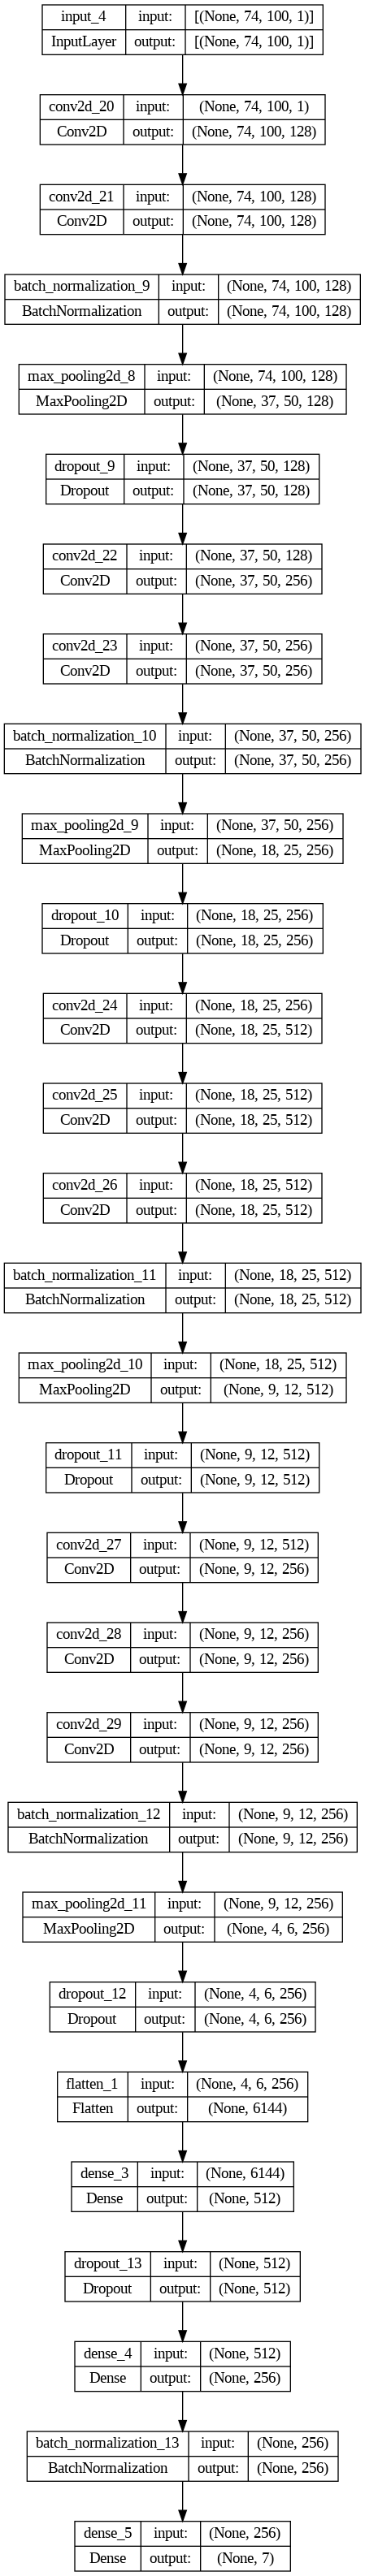

In [ ]:
#input
input = Input(shape=(74, 100, 1))

x = Conv2D(filters = 128, kernel_size=3, padding = 'same', activation='relu')(input)
x = Conv2D(filters = 128, kernel_size=3, padding = 'same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(filters = 256, kernel_size=3, padding = 'same', activation='relu')(x)
x = Conv2D(filters = 256, kernel_size=3, padding = 'same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(filters = 512, kernel_size=3, padding = 'same', activation='relu')(x)
x = Conv2D(filters = 512, kernel_size=3, padding = 'same', activation='relu')(x)
x = Conv2D(filters = 512, kernel_size=3, padding = 'same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(filters = 256, kernel_size=3, padding = 'same', activation='relu')(x)
x = Conv2D(filters = 256, kernel_size=3, padding = 'same', activation='relu')(x)
x = Conv2D(filters = 256, kernel_size=3, padding = 'same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)

x = Dense(units=512, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(units=256, activation='relu')(x)
x = BatchNormalization()(x)

output = Dense(7, activation='softmax')(x)

model = Model(inputs = input, outputs=output)
plot_model(model, show_shapes=True)
# model.summary()

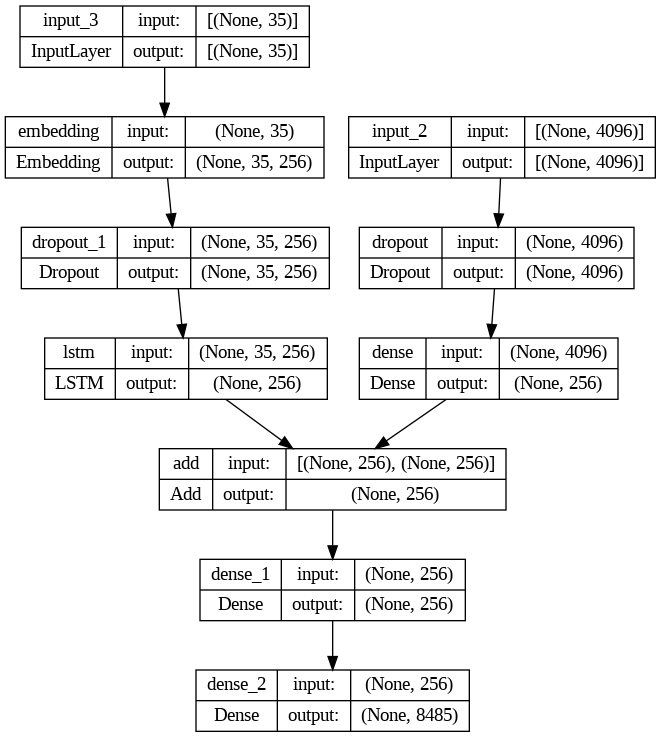

In [ ]:
#Encoder Model
#Image layer
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

#Sequence layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

#Decoder Model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

###Fit Model

In [ ]:
batch_size = 32
# steps = len(train) // batch_size
steps = 100

train_generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
test_generator = data_generator(test, mapping, features, tokenizer, max_length, vocab_size, batch_size)

history = model.fit(train_generator,
                    epochs=50,
                    steps_per_epoch = steps,
                    validation_data = test_generator,
                    validation_steps = 50)

Epoch 1/50
100/100 [==============================] - 60s 532ms/step - loss: 5.7048 - val_loss: 5.1469
Epoch 2/50
100/100 [==============================] - 46s 459ms/step - loss: 4.9554 - val_loss: 4.5766
Epoch 3/50
100/100 [==============================] - 44s 437ms/step - loss: 4.3182 - val_loss: 4.1953
Epoch 4/50
100/100 [==============================] - 42s 424ms/step - loss: 3.9958 - val_loss: 4.0738
Epoch 5/50
100/100 [==============================] - 41s 414ms/step - loss: 3.8411 - val_loss: 3.9804
Epoch 6/50
100/100 [==============================] - 42s 424ms/step - loss: 3.6221 - val_loss: 3.9258
Epoch 7/50
100/100 [==============================] - 42s 425ms/step - loss: 3.5310 - val_loss: 3.9047
Epoch 8/50
100/100 [==============================] - 42s 422ms/step - loss: 3.3850 - val_loss: 3.8140
Epoch 9/50
100/100 [==============================] - 41s 410ms/step - loss: 3.3371 - val_loss: 3.8440
Epoch 10/50
100/100 [==============================] - 42s 417ms/step - l

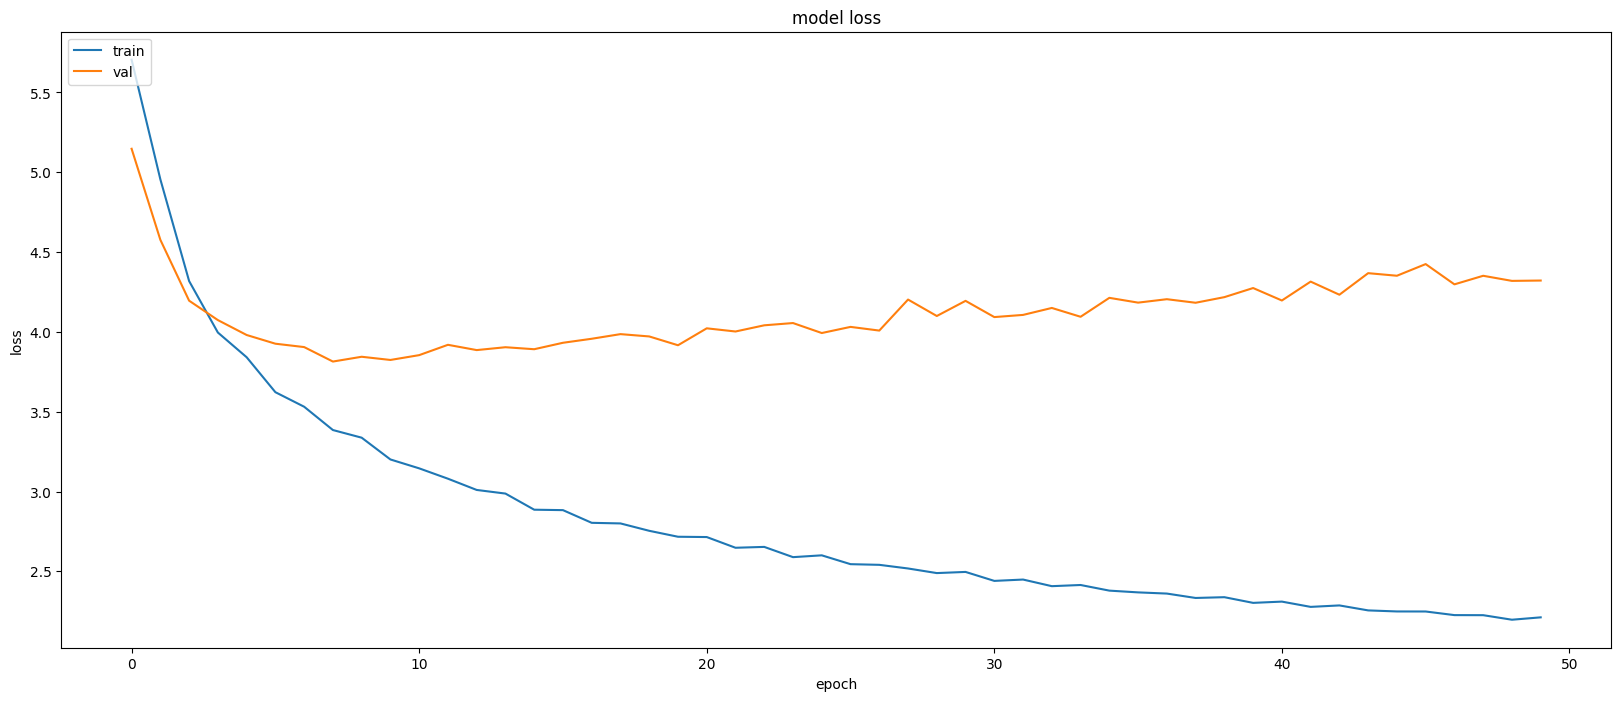

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save('best_model.h5')

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
    #Thêm start tag
    in_text = 'startseq'
    for i in range(max_length):
        #Encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        #Pad the sequence
        sequence = pad_sequences([sequence], max_length)
        #Dự đoán từ tiếp theo
        yhat = model.predict([image, sequence], verbose=0)
        # print("y_hat: ", yhat)
        #Nhận index của từ có xác suất cao nhất
        yhat = np.argmax(yhat)
        # print("choose:", yhat)
        #Chuyển index thành word
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        #Thêm từ vào input để dự đoán từ tiếp theo
        in_text += " " + word
        #Dừng vòng lặp khi gặp endseq
        if word == 'endseq':
            break

    return in_text

##**Evaluation**

In [ ]:
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

#BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.562515
BLEU-2: 0.338407


In [ ]:
def generate_caption(image_name):

    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR , image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq man racing on motorbike endseq
startseq motorcycle rider drives fast around curve on track endseq
startseq person wearing red and white uniform is racing motorcycle with the number 58 on it endseq
startseq red and white motorcycle is being ridden around bend on racetrack endseq
startseq red and white motorbike number 58 races around the track endseq
--------------------Predicted--------------------
startseq the motorcycle rider is racing around track endseq


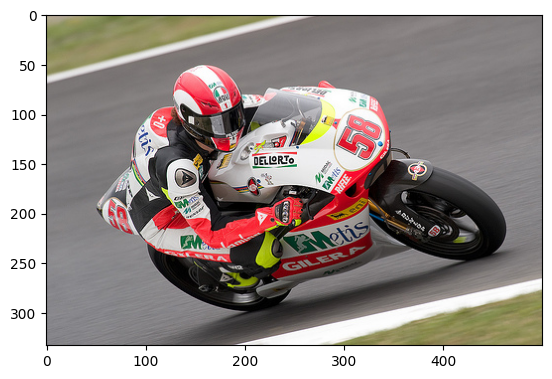

In [ ]:
path_to_images = '/content/Flickr_Data/Images'
image_list = os.listdir(path_to_images)
random_image = random.choice(image_list)
generate_caption(random_image)

In [ ]:
def check_caption(image_path):
    model = VGG19()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    caption_model = load_model('/content/best_model.h5')

    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    feature = model.predict(image, verbose=0)

    caption = predict_caption(caption_model, feature, tokenizer, max_length)
    print(caption)

    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()

startseq dog runs through the grass endseq


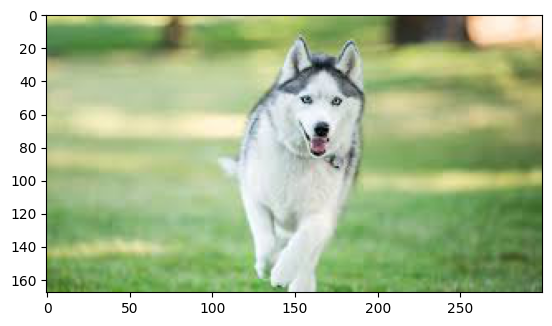

In [ ]:
img_path = '/content/images.jpg'
check_caption(img_path)

startseq skateboarder is performing jump endseq


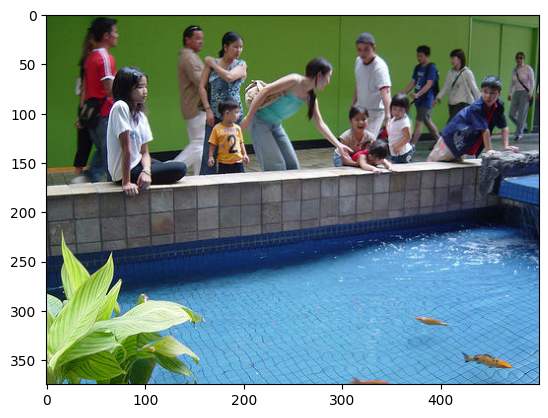

In [ ]:
img_path = '/content/pic8.jpg'
check_caption(img_path)

startseq hiker is climbing rocky mountainside endseq


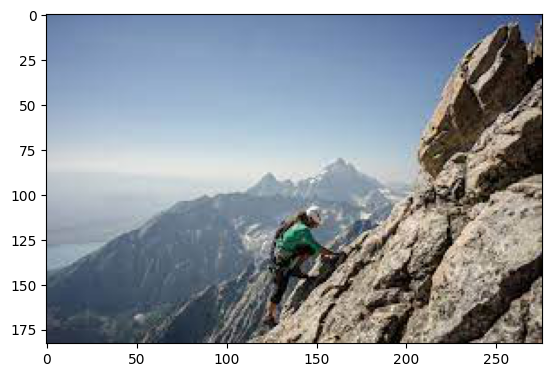

In [ ]:
img_path = '/content/climb.jpg'
check_caption(img_path)

In [ ]:
img_path = '/content/blackdogrun.jpg'
check_caption(img_path)